# Test inference

This is a helper notebook to test and visualize the inferences done by the demo edge device deployed as part of the MLOps @ Edge example. 

In [ ]:
# create required thing and certificates to allow communication wiht AWS IoT core
THING_NAME="inference-notebook"
!certs/create-thing.sh $THING_NAME
ENDPOINT=!aws iot describe-endpoint --endpoint-type iot:Data-ATS --output text
ENDPOINT = ENDPOINT[0]
print(f'Endpoint is {ENDPOINT}')^

In [ ]:
THING_NAME="inference-notebook"
ENDPOINT=!aws iot describe-endpoint --endpoint-type iot:Data-ATS --output text
ENDPOINT = ENDPOINT[0]
print(f'Endpoint is {ENDPOINT}')

In [ ]:
# install required dependencies
!apt-get -qq update
!apt-get install -qq ffmpeg libsm6 libxext6  -y
!pip install -qq paho-mqtt gluoncv mxnet opencv-python

In [4]:
import paho.mqtt.client as paho
import os
import socket
import ssl
from time import sleep
from random import uniform
import json
import traceback
import logging
logging.basicConfig(level=logging.INFO)
import json
from gluoncv.utils import download, viz
import cv2
from matplotlib import pyplot as plt
import numpy as np
classes = ['scratch']
from IPython.display import clear_output
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image


class PubSub(object):

    def __init__(self, listener = False, topic = "default"):
        self.connect = False
        self.listener = listener
        self.topic = topic
        self.logger = logging.getLogger(repr(self))

    def __visualize_payload(self,message_string):
        clear_output(wait=True)
        inference_message = json.loads(message_string)
        print(inference_message['inference_results'])
        image = f"../inference/lib/assets/gg_components/artifacts/qualityinspection/sample_images/{inference_message['image_name']}"
        bboxes = np.array(inference_message['inference_results'][0][1][0])
        ##bboxes = self.scale_bounding_boxes(bboxes,450,450,450,300) 
        score = np.array(inference_message['inference_results'][0][0][0])
        cid = np.zeros(len(bboxes))
        self.logger.info(f"Received predictions for image {inference_message['image_name']} bbox: {bboxes} score {score}")
        self.plot_bounding_boxes(image, bboxes, score)
        
        #viz.plot_bbox(image, bbox,score,cid, class_names=classes, thresh=0.01)
        plt.show()
    def __on_connect(self, client, userdata, flags, rc):
        self.connect = True
        
        if self.listener:
            self.mqttc.subscribe(self.topic)

        self.logger.debug("{0}".format(rc))

    def __on_message(self, client, userdata, msg):
        
        #self.logger.info("{0}, {1} - {2}".format(userdata, msg.topic, msg.payload))
        try:
            message_string = msg.payload.decode()
            self.__visualize_payload(message_string)
        except:
            traceback.print_exc()
            pass

    def __on_log(self, client, userdata, level, buf):
        self.logger.debug("{0}, {1}, {2}, {3}".format(client, userdata, level, buf))


    
    def bootstrap_mqtt(self):

        self.mqttc = paho.Client()
        self.mqttc.on_connect = self.__on_connect
        self.mqttc.on_message = self.__on_message
        self.mqttc.on_log = self.__on_log

        awshost = ENDPOINT
        awsport = 8883

        caPath = "./certs/AmazonRootCA1.pem" # Root certificate authority, comes from AWS with a long, long name
        certPath = f"./certs/{THING_NAME}-certificate.pem.crt"
        keyPath = f"./certs/{THING_NAME}-private.pem.key"

        self.mqttc.tls_set(caPath, 
            certfile=certPath, 
            keyfile=keyPath, 
            cert_reqs=ssl.CERT_REQUIRED, 
            tls_version=ssl.PROTOCOL_TLSv1_2, 
            ciphers=None)

        result_of_connection = self.mqttc.connect(awshost, awsport, keepalive=120)

        if result_of_connection == 0:
            self.connect = True

        return self


    def scale_bounding_boxes(self,bounding_boxes, orig_width, orig_height, new_width, new_height):
        scaled_boxes = []
        width_ratio = new_width / orig_width
        height_ratio = new_height / orig_height

        for bbox in bounding_boxes:
            x, y, width, height = bbox

            scaled_x = x * width_ratio
            scaled_y = y * height_ratio
            scaled_width = width * width_ratio
            scaled_height = height * height_ratio

            scaled_boxes.append([scaled_x, scaled_y, scaled_width, scaled_height])

        return scaled_boxes
    
    
    def plot_bounding_boxes(self,image_path, bounding_boxes, confidence_scores):
        # Load the image
        image = Image.open(image_path)

        # Create a figure and axis
        fig, ax = plt.subplots(1)

        # Display the image
        ax.imshow(image)

        # Iterate over the bounding boxes
        for bbox, score in zip(bounding_boxes, confidence_scores):
            # Extract the coordinates
            x, y, width, height = bbox

            # Create a rectangle patch
            rect = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor='r', facecolor='none')

            # Add the rectangle patch to the axis
            ax.add_patch(rect)

            # Add the confidence score as text
            ax.text(x, y, f'{score:.2f}', color='r', fontsize=8)

        # Show the plot
        plt.show()
    
    
    def start(self):
        self.mqttc.loop_start()

        while True:
            sleep(2)
            if self.connect == True:
                pass
                #print("Connected")
                #self.mqttc.publish(self.topic, json.dumps({"message": "Hello COMP680"}), qos=1)
            else:
                self.logger.debug("Attempting to connect.")  
    

        


INFO:<__main__.PubSub object at 0x7f309c7b70d0>:Received predictions for image image-2020-04-22-10-51-51-85-cropped-right-bottom.jpg bbox: [] score []


[[[[]], [[]]]]


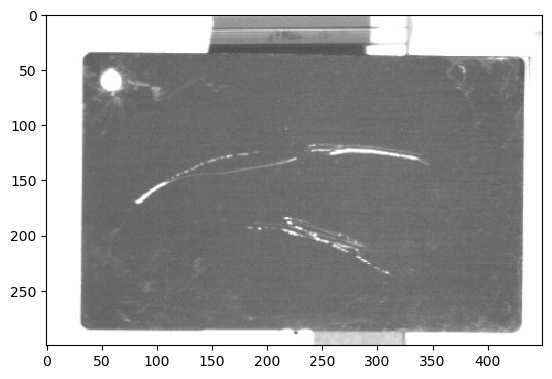

In [5]:
PubSub(listener = True, topic = "qualityinspection/scratch-detection").bootstrap_mqtt().start()